In [262]:
import copy

import cv as cv
import numpy as np
import cv2
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import skimage
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

PATH = "C:/Users/cubix/Desktop/analiza-obrazow-cyfrowych-projekt/data/DATASET/"
os.listdir(PATH)

['downdog', 'goddess', 'plank', 'tree', 'warrior']

In [263]:
dataset = []
labels = []

for classes in os.listdir(PATH):
    for image in os.listdir(PATH + classes):
        img = cv2.imread(PATH + classes + '/' + image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(img, (200, 200))
        dataset.append(resized)
        labels.append(classes)

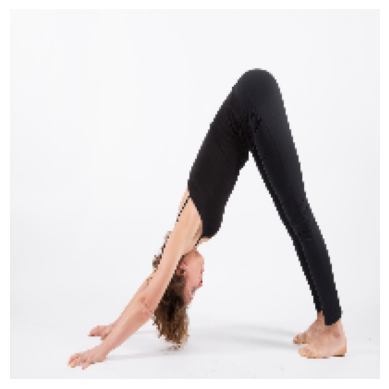

In [264]:
sample_idx = 0
plt.axis('off')
plt.imshow(dataset[sample_idx])
plt.show()

In [265]:
dataset_array = np.asarray(dataset)
canny_list = []

for sample in range(len(dataset_array)):
    gray_img = cv2.cvtColor(dataset_array[sample], cv2.COLOR_RGB2GRAY)
    new_img = skimage.feature.canny((gray_img))
    canny_list.append(new_img)

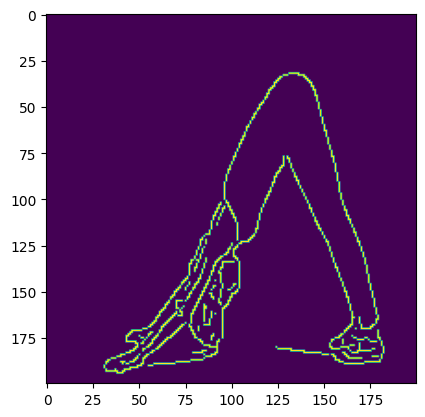

In [266]:
plt.imshow(canny_list[sample_idx])
plt.show()

In [267]:
sample = canny_list[sample_idx]
indices = list(zip(*np.where(sample == 1)))

In [268]:
list(np.mean(indices, axis=0))

[140.5797213622291, 109.36300309597523]

In [299]:
new_img = copy.deepcopy(canny_list[sample_idx])
step = 50
block_points = []

for x_block in range(0, 200, step):
    for y_block in range(0, 200, step):
        indices = list(zip(*np.where(new_img[y_block:y_block+step, x_block:x_block+step] == 1)))
        try:
            if len(indices) > 50:
                mean_indices = list(np.mean(indices, axis=0))
                block_points.append([(y_block, int(mean_indices[0])), (x_block, int(mean_indices[1]))])
        except IndexError:
            continue
block_points

[[(150, 34), (0, 42)],
 [(100, 31), (50, 37)],
 [(150, 19), (50, 24)],
 [(0, 39), (100, 31)],
 [(50, 26), (100, 22)],
 [(100, 20), (100, 14)],
 [(100, 27), (150, 13)],
 [(150, 25), (150, 17)]]

In [300]:
points = [(block_points[idx][1][0] + block_points[idx][1][1], block_points[idx][0][0] + block_points[idx][0][1]) for idx in range(len(block_points))]
points

[(42, 184),
 (87, 131),
 (74, 169),
 (131, 39),
 (122, 76),
 (114, 120),
 (163, 127),
 (167, 175)]

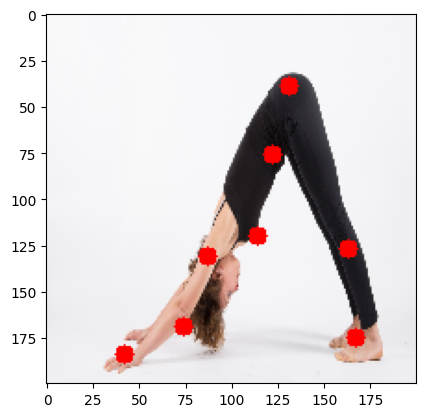

In [301]:
rgb_image = copy.deepcopy(dataset[sample_idx])
for point in points:
    rgb_image = cv2.circle(rgb_image, point, radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

In [302]:
mass_x, mass_y = np.where(canny_list[20] == 1)
cent_x = np.average(mass_x)
cent_y = np.average(mass_y)

In [303]:
cent_x

109.88679752621672

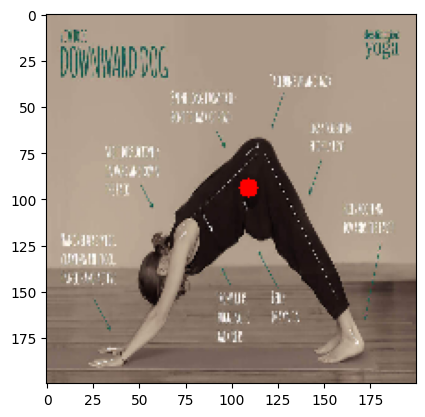

In [304]:
rgb_image = copy.deepcopy(dataset[20])
# for point in points:
rgb_image = cv2.circle(rgb_image, (int(cent_x), int(cent_y)), radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(rgb_image)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------

In [276]:
gray_sample = cv2.cvtColor(dataset[sample_idx], cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(gray_sample, cv2.MORPH_CLOSE, kernel, iterations=3)
erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)

mask = np.zeros(gray_sample.shape[:2], np.uint8)
mask[:] = 2
mask[erosion == 255] = 1
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)

out_mask = mask.copy()
out_mask, _, _ = cv2.grabCut(gray_sample, out_mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)
out_mask = np.where((out_mask==2)|(out_mask==0),0,1).astype('uint8')
out_img = dataset[sample_idx]*out_mask[:,:,np.newaxis]

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\grabcut.cpp:557: error: (-5:Bad argument) image must have CV_8UC3 type in function 'cv::grabCut'
